The purpose of this notebook is to conduct K-Fold CV using two techniques called purging and embargoing, and to experiment the effectiveness of the method by comparing the performance between the model that learns raw data and the modl that learns the data processed by embargoing and purging. 

- Purging is to remove labels in the train set that have infomational overlap with the ones in the test set.
- Embargoing is to remove lookback-based features (=the corresponding labels) that are computed using information that can only be seen in the test set. 

In [63]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [4]:
def get_info_used(df):
    
    """
    df: A pandas dataframe, with columns,
     y_buy: A primary model's return from a long position
     y_sell: A primary model's return from a short position. 
     exit_price_sell: The prices at which each short position is exited
     exit_price_buy: The prices at which each long position is exited.
     buy_executed: 1 if a limit buy order is filled at the next timestamp and 0 otherwise.
     sell_executed:  1 if a limit sell order is filled at the next timestamp and 0 otherwise.
     # More details explained in calc returns with dynamic pt sl orders.ipynb.
     
    info_used_buy/sell:its indexes are entry date, and its values are exit date
    
    """
    #entry date
    info_used_buy=pd.DataFrame(pd.to_datetime(df.query('buy_executed==1')['buy_exit_date'],format='%Y%m%d %H:%M'),index=df.query('buy_executed==1').index)
    info_used_sell=pd.DataFrame(pd.to_datetime(df.query('sell_executed==1')['sell_exit_date'],format='%Y%m%d %H:%M'),index=df.query('sell_executed==1').index)
    
    #exit date (buy_executed==1だけ取ってんねんな)
    t1_buy=pd.DataFrame(info_used_buy.values, columns=['dummy']).dropna()
    t1_sell=pd.DataFrame(info_used_sell.values, columns=['dummy']).dropna()

    return info_used_buy,info_used_sell,t1_buy,t1_sell

In [71]:
def get_idenM(df,info_used,t1):
    
    """
    t1: t1_buy/sell
    info_used:info_used_buy/sellのindexがエントリー日、valuesがエグジット日
    df:A dataframe whose indexes are all the timestamps related to a strategy development, and whose cols are range(df.shape[0])

    """
    df=df.dropna(subset=['buy_exit_date'])
    #idenM.indexはinfo_used.indexとは毛色が違う
    idenM=pd.DataFrame(np.nan,index=df.index,columns=range(info_used.shape[0]))
    t1=t1.set_index('dummy')# dummyをインデックスにすることで、info_used_buy.valuesがインデックスに変換される
    
    #idenM.indexに存在しない日付を指定していることが原因⇒t1.index[-1]が
    for i,(t0,t1) in enumerate(zip(info_used.index,t1.index)):
        try:
            idenM.loc[t0:t1,i]=1
            
        except:
            break
        
    idenM=idenM.fillna(0)
    return idenM

In [6]:
def remove_all_zero_row(df):
    
    df = df.copy()
    for row in df.index:
        if (df.loc[row] == 0).all():
            df.drop(row, axis=0, inplace=True)
    return df

In [8]:
def purge_labels(df,side,cv_indicies):
    
    """
    input
    -cv_indicies:cv_indicies_embargoed
    -side:'buy' if you male a ML model to learn a buy strategy
    -df:A pandas dataframe containing features and labels
    
    out
    -dfs:A list whose element is a turple of a purged and embargoed train set and its test set
    
    """
   
   
    dfs=[]# The element is a turple that contains a purged train set and a test set.
    
    for train,test in cv_indicies:
        df_train=df.iloc[train]
        df_test=df.iloc[test]
        
        a=set(df_train['buy_exit_date'])
        b=set(df_test.index)
        c=list(a.intersection(b))
        
        #Solving an overlap between buy_exit_date and testset.index means avoding an error 
        #related to t1 in get_idenM
        
        for d in c:
            df_train=df_train[df_train['buy_exit_date']!=d]
        
        if side=='buy':
            start_buy,start_sell,end_buy,end_sell=get_info_used(df_train)
            idenM_train=get_idenM(df_train,start_buy,end_buy)
            idenM_train=remove_all_zero_row(idenM_train)
            
            # The set of the timestamps used to compute the labels in the train set 
            info_set_train=set(idenM_train.index)
            
            start_buy,start_sell,end_buy,end_sell=get_info_used(df_test)
            idenM_test=get_idenM(df_test,start_buy,end_buy)
            idenM_test=remove_all_zero_row(idenM_test)
            
            # The set of the timestamps used to compute the labels in the test set 
            info_set_test=set(idenM_test.index)
            
        elif side=='sell':
            start_buy,start_sell,end_buy,end_sell=get_info_used(df_train)
            idenM_train=get_idenM(df_train,start_sell,end_sell)
            idenM_train=remove_all_zero_row(idenM_train) 
            info_set_train=set(idenM_train.index)
            
            start_buy,start_sell,end_buy,end_sell=get_info_used(df_test)
            idenM_test=get_idenM(df_test,start_sell,end_sell)
            idenM_test=remove_all_zero_row(idenM_test)
            info_set_test=set(idenM_test.index)
            
        info_set_overlapped=info_set_test.intersection(info_set_train) 
        obs_dropped=set(df_train.index).intersection(info_set_overlapped)

        df_train_purged=df_train.drop(index=list(obs_dropped))
        dfs.append((df_train_purged,df_test))
        
    return dfs

In [9]:
def embargo(df,span):
    
    """
    input
    -df:A pandas dataframe containing features and labels
    -span: The largestinteger used to compute lookback-based features
    
    return
    -cv_indicies_embargoed:A list whose element is a turple of the indicies 
                           for a train and test set. 
    
    """
    df=df.dropna(subset=['buy_exit_date'])
    cv_indicies = list(KFold().split(df))
    cv_indicies_embargoed=[]
    
    for tr,tes in cv_indicies:
        if tr[-1]>tes[-1]:
            # The case where the test set is between the separated train sets.
            # The sum of the indicies of the train set to the left of the test set and 
            # the indicies of the train set to the right of the test set.
            cv_indicies_embargoed.append((np.r_[tr[tr<tes[0]],tr[tr>tes[-1]][span:]],tes))  
        
        else:
            cv_indicies_embargoed.append((tr,tes))
    return cv_indicies_embargoed

In [ ]:
def calc_pred_in_pcv(estimator,df,dfs_purged,features,target):
    
    y_pred=df['y_buy'].copy()
    y_pred.iloc[:]=np.nan
    
    for train,test in dfs_purged:
        model.fit(train[features],train[target])
        y_pred.loc[test.index]=model.predict(test[features])
    return y_pred

In [68]:
def calc_pred_in_cv(df,estimator, X, y=None):
    
    '''
    input
    -X:df[features]
    -y:df['y_buy/sell']
    
    '''
    y_pred = df['y_buy'].copy()
    y_pred.iloc[:] = np.nan
    
    cv_indicies = list(KFold().split(df))
    
    for train_idx, val_idx in cv_indicies:
        estimator.fit(X.iloc[train_idx], y.iloc[train_idx])
        y_pred.iloc[val_idx] = estimator.predict(X.iloc[val_idx])
    return y_pred

In [10]:
df=pd.read_parquet('df_new')
df

,open,high,low,close,maker fee,daily vol,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,...,Upper,Lower,buy_executed,sell_executed,buy_exit_date,exit_price_buy,y_buy,sell_exit_date,exit_price_sell,y_sell
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-02-23 05:50:00,49963.0,50600.0,48779.5,50060.0,-0.00025,0.029728,1565.719965,416.25,-733.219965,1207.837059,...,NaN,NaN,1,1,2021-02-23 06:35:00,50094.5,0.010622,2021-02-23 06:35:00,50094.5,-0.008070
2021-02-23 06:20:00,50842.0,51216.5,49530.0,50700.0,-0.00025,0.029862,809.986002,-288.85,-1387.686002,425.403967,...,51003.0,50094.5,1,0,2021-02-23 07:05:00,49562.0,-0.012327,2021-02-23 06:35:00,NaN,0.000000
2021-02-23 06:35:00,50700.0,50863.5,50005.0,50169.0,-0.00025,0.030253,469.817542,-457.05,-1383.917542,211.108081,...,50472.5,49562.0,1,0,2021-02-23 07:35:00,50166.5,0.010303,2021-02-23 07:05:00,NaN,0.000000
2021-02-23 07:05:00,49740.0,50465.0,49474.0,49860.5,-0.00025,0.030670,911.688266,69.70,-772.288266,501.199109,...,50166.5,49249.0,0,1,2021-02-23 07:35:00,NaN,0.000000,2021-02-23 07:50:00,49938.5,-0.007683
2021-02-23 07:35:00,50062.5,50560.5,49606.5,50558.0,-0.00025,0.030639,811.992971,186.00,-439.992971,318.906714,...,50868.0,49938.5,1,0,2021-02-23 08:05:00,49178.5,-0.017285,2021-02-23 07:50:00,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-16 00:20:00,22650.5,22694.0,22398.0,22555.0,0.00010,0.053747,145.796931,39.90,-65.996931,-189.536198,...,22797.5,22070.0,0,1,2022-06-16 00:35:00,NaN,0.000000,2022-06-16 01:05:00,22771.0,-0.001669
2022-06-16 00:35:00,22555.0,22877.5,22464.5,22527.5,0.00010,0.054057,10.670640,-101.20,-213.070640,-266.317196,...,22771.0,22040.5,0,1,2022-06-16 01:05:00,NaN,0.000000,2022-06-16 01:05:00,NaN,0.000000
2022-06-16 01:05:00,22667.5,23032.5,22424.5,22951.5,0.00010,0.054733,239.011717,-91.70,-422.411717,-228.163243,...,23202.5,22449.0,1,0,2022-06-16 01:20:00,NaN,0.000000,2022-06-16 01:20:00,NaN,0.000000


In [42]:
cv_indicies_embargoed=embargo(df,span=30)

In [52]:
dfs_purged=purge_labels(df,side='buy',cv_indicies=cv_indicies_embargoed)
dfs_purged

[(                        open     high      low    close  maker fee  daily vol  \
  timestamp                                                                       
  2021-05-01 16:05:00  57314.5  57491.5  57314.5  57490.5   -0.00025   0.038285   
  2021-05-01 16:20:00  57490.5  57670.5  57335.0  57368.5   -0.00025   0.038289   
  2021-05-01 16:35:00  57368.5  57406.0  57305.5  57349.5   -0.00025   0.038293   
  2021-05-01 17:35:00  57733.5  57754.5  57569.0  57592.0   -0.00025   0.038055   
  2021-05-01 17:50:00  57592.0  57645.0  57510.0  57582.5   -0.00025   0.037871   
  ...                      ...      ...      ...      ...        ...        ...   
  2022-06-16 00:05:00  22583.5  22800.0  22476.0  22650.5    0.00010   0.053627   
  2022-06-16 00:20:00  22650.5  22694.0  22398.0  22555.0    0.00010   0.053747   
  2022-06-16 00:35:00  22555.0  22877.5  22464.5  22527.5    0.00010   0.054057   
  2022-06-16 01:05:00  22667.5  23032.5  22424.5  22951.5    0.00010   0.054733   
  20

In [34]:
model=lgb.LGBMRegressor(n_jobs=-1,random_state=1)
model=BaggingRegressor(model,random_state=1,n_jobs=1)
features = ['ADX', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'ATR',
       'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA',
       'CCI', 'DX', 'EMA', 'HT_TRENDMODE', 'KAMA', 'LINEARREG',
       'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA','MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk',
       'STOCH_slowd', 'STOCH_slowk', 'T3', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA']

In [55]:
df['y_pred_buy_by_pcv']=calc_pred_in_pcv(model,df,dfs_purged,features,'y_buy')# no leak from feats and label

In [69]:
df['y_pred_buy_by_cv']=calc_pred_in_cv(df,model,df[features],df['y_buy'])#leak from feats and label

Cumulative ret when predicted ret>0


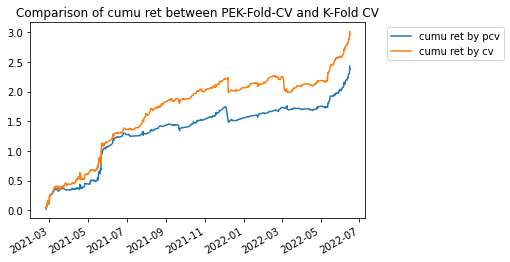

In [70]:
df = df.dropna()

print('Cumulative ret when predicted ret>0')
fig,ax=plt.subplots()

ax.plot(df[df['y_pred_buy_by_pcv'] > 0]['y_buy'].cumsum(),label='cumu ret by pcv')
ax.plot(df[df['y_pred_buy_by_cv'] > 0]['y_buy'].cumsum(),label='cumu ret by cv')

ax.set_title('Comparison of cumu ret between PEK-Fold-CV and K-Fold CV')
ax.legend(bbox_to_anchor=(1.05, 1))
plt.gcf().autofmt_xdate() 